In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

In [3]:
class CNN2D(nn.Module):
    def __init__(self):
        super(CNN2D, self).__init__()
        self.first_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5, 5), padding=2),
            nn.BatchNorm2d(32), 
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3))
        self.adjustment1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1)),
            nn.BatchNorm2d(64)
        )
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(1, 1)),
            nn.BatchNorm2d(64)
        )
        self.adjustment2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, 1)),
            nn.BatchNorm2d(128)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=128, kernel_size=(1, 1)),
            nn.BatchNorm2d(128)
        )
        self.adjustment3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1, 1)),
            nn.BatchNorm2d(256)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=(1, 1)),
            nn.BatchNorm2d(256)
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d((2, 2))
        self.flatten = nn.Flatten()
        self.dense_layer = nn.Sequential(
            nn.Linear(256 * 2 * 2, 1)
        )

    def forward(self, x):
        x = self.first_layer(x)

        x = self.pool1(x)
        
        identity = self.adjustment1(x)
        x = self.block1(x)
        x = x + identity 
        x = F.relu(x)

        identity = self.adjustment2(x)
        x = self.block2(x)
        x = x + identity 
        x = F.relu(x)

        identity = self.adjustment3(x)
        x = self.block3(x)
        x = x + identity 
        x = F.relu(x)

        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.dense_layer(x)
        return x

In [4]:
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return image

In [5]:
def image_to_tensor(image):
    transform_pipeline = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])
    return transform_pipeline(image)

In [ ]:
df = []
for i in range(2):
    for j in range(3500):
        if j != 666:
            image_path = f'../../data/PetImages/Cat/{j}.jpg' if i == 0 else f'../../data/PetImages/Dog/{j}.jpg'
            
            pil_image = load_image(image_path)
            
            image_tensor = image_to_tensor(pil_image)
    
            df.append(image_tensor)

In [6]:
df = torch.stack(df)

In [7]:
y = torch.cat((torch.zeros(3499), torch.ones(3499)), dim=0)

In [8]:
xTrain, xTest, yTrain, yTest = train_test_split(df, y, train_size=0.7, random_state=42)
del df
del y

In [9]:
yTrain_tensor = yTrain.detach().clone().view(-1, 1) 
yTest_tensor = yTest.detach().clone().view(-1, 1)

In [10]:
train_dataset = TensorDataset(xTrain, yTrain_tensor)
test_dataset = TensorDataset(xTest, yTest_tensor)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
validation_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
del xTrain, xTest, yTrain, yTest

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN2D().to(device)
print(model)

CNN2D(
  (first_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (adjustment1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block1): Sequential(
    (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [8]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Parameters: {total_params:,}")
print(f"Treinable parameters: {trainable_params:,}")

Parameters: 130,529
Treinable parameters: 130,529


In [15]:
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)
num_epochs = 150
history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

In [16]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for (inputs, labels) in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs,labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc)

    model.eval() 
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(validation_loader)
    epoch_val_acc = correct_val / total_val
    history['val_loss'].append(epoch_val_loss)
    history['val_accuracy'].append(epoch_val_acc)

    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_acc:.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.7f}')

Epoch [1/150], Loss: 0.6452, Accuracy: 0.5923, Val Loss: 0.6947, Val Accuracy: 0.5948, Learning Rate: 0.0010000
Epoch [2/150], Loss: 0.6187, Accuracy: 0.6258, Val Loss: 0.6860, Val Accuracy: 0.6114, Learning Rate: 0.0010000
Epoch [3/150], Loss: 0.5793, Accuracy: 0.6674, Val Loss: 0.6656, Val Accuracy: 0.6319, Learning Rate: 0.0010000
Epoch [4/150], Loss: 0.5609, Accuracy: 0.6872, Val Loss: 0.7234, Val Accuracy: 0.6281, Learning Rate: 0.0010000
Epoch [5/150], Loss: 0.5319, Accuracy: 0.7111, Val Loss: 0.5604, Val Accuracy: 0.7181, Learning Rate: 0.0010000
Epoch [6/150], Loss: 0.5115, Accuracy: 0.7266, Val Loss: 0.7108, Val Accuracy: 0.5976, Learning Rate: 0.0010000
Epoch [7/150], Loss: 0.4790, Accuracy: 0.7503, Val Loss: 0.5653, Val Accuracy: 0.7081, Learning Rate: 0.0010000
Epoch [8/150], Loss: 0.4708, Accuracy: 0.7591, Val Loss: 0.6380, Val Accuracy: 0.7062, Learning Rate: 0.0010000
Epoch [9/150], Loss: 0.4500, Accuracy: 0.7797, Val Loss: 0.5718, Val Accuracy: 0.7576, Learning Rate: 0.

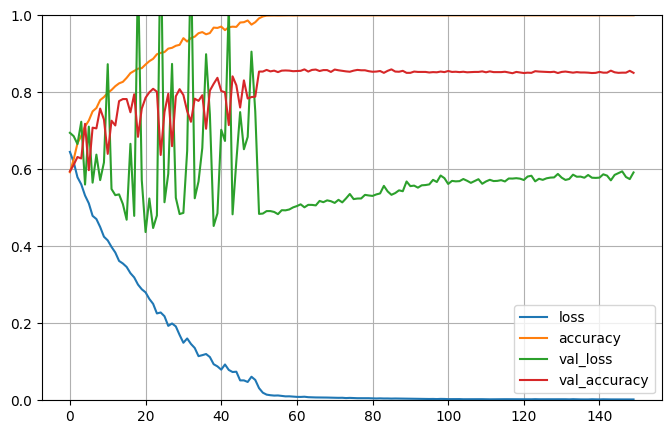

In [17]:
pd.DataFrame(history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [18]:
model.eval()
all_preds = []
all_labels = []
all_probas = []

In [19]:
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)

        outputs = outputs.cpu()
        labels = labels.cpu()

        probas = outputs.numpy()
        preds = (probas > 0.5).astype(int)

        all_probas.extend(probas.flatten())
        all_preds.extend(preds.flatten())
        all_labels.extend(labels.numpy().flatten())

In [20]:
print(confusion_matrix(all_labels, all_preds))

[[934 146]
 [168 852]]


In [21]:
print(accuracy_score(all_labels, all_preds))

0.8504761904761905


In [22]:
fpr, tpr, _ = roc_curve(all_labels, all_probas)
roc_auc = auc(fpr, tpr)

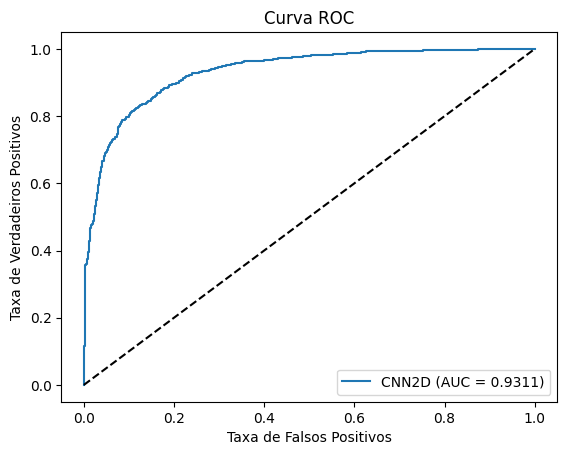

In [23]:
plt.figure()
plt.plot(fpr, tpr, label=f'CNN2D (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()